**Machine learning starter program**

https://datahack.analyticsvidhya.com/contest/machine-learning-starter-program-hackathon/#ProblemStatement


In [0]:
## import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import IterativeImputer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
! pip install pycaret
from pycaret.classification import *
import scipy.stats as stats
from sklearn.utils import resample
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE

# Data read

In [0]:
## Read from google drive
train = pd.read_csv("drive/My Drive/MachineLearning-Starter program - analyticsvidhya/train_HK6lq50.csv")
test = pd.read_csv("drive/My Drive/MachineLearning-Starter program - analyticsvidhya/test_wF0Ps6O.csv")

In [0]:
train.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0
1,16523_44,T_1,T,131,44,offline,easy,16523,F,High School Diploma,4,26.0,2,N,3.0,1
2,13987_178,Z_2,Z,120,178,online,easy,13987,M,Matriculation,1,40.0,1,N,2.0,1
3,13158_32,T_2,T,117,32,offline,easy,13158,F,Matriculation,3,NaN,4,N,1.0,1
4,10591_84,V_3,V,131,84,offline,intermediate,10591,F,High School Diploma,1,42.0,2,N,4.0,1


In [0]:
test.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating
0,1626_45,T_1,T,131,45,offline,intermediate,1626,F,Matriculation,3,46.0,2,N,4.0
1,11020_130,Y_3,Y,135,130,online,easy,11020,M,Bachelors,3,NaN,4,N,4.0
2,12652_146,Y_2,Y,120,146,online,easy,12652,M,Matriculation,3,NaN,2,N,3.0
3,7038_72,V_4,V,122,72,offline,vary hard,7038,F,High School Diploma,1,NaN,2,N,2.0
4,888_71,V_4,V,122,71,offline,intermediate,888,F,Matriculation,3,NaN,2,N,2.0


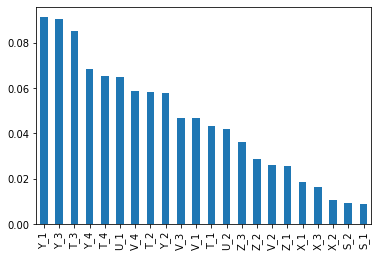

In [0]:
train['program_id'].value_counts(normalize=True).plot(kind="bar")

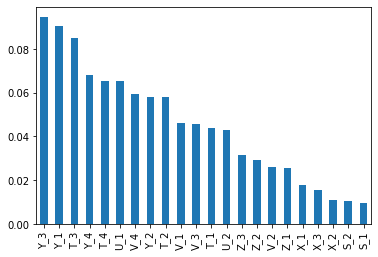

In [0]:
test['program_id'].value_counts(normalize=True).plot(kind="bar")

In [0]:
train.isnull().sum()

id                               0
program_id                       0
program_type                     0
program_duration                 0
test_id                          0
test_type                        0
difficulty_level                 0
trainee_id                       0
gender                           0
education                        0
city_tier                        0
age                          27729
total_programs_enrolled          0
is_handicapped                   0
trainee_engagement_rating       77
is_pass                          0
dtype: int64

# Filling NA values in age and rating

## Age imputation

In [0]:
train['age'].describe()

count    45418.000000
mean        36.494033
std          9.041119
min         17.000000
25%         28.000000
50%         39.000000
75%         45.000000
max         63.000000
Name: age, dtype: float64

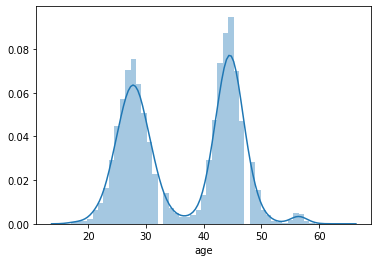

In [0]:
sns.distplot(train['age'])
plt.show()

In [0]:
train['program_type'].unique()

array(['Y', 'T', 'Z', 'V', 'U', 'X', 'S'], dtype=object)

In [0]:
train['trainee_engagement_rating'].value_counts()

1.0    25595
2.0    17234
4.0    13113
3.0    11553
5.0     5575
Name: trainee_engagement_rating, dtype: int64

In [0]:
# Lets fill mode value for each program type
def impute_missing_values(df):
  program = df['program_type'].unique()
  final = []
  for program_name in program:
    one_program  = df[df['program_type'] == program_name]
    mode_age = one_program['age'].value_counts().index[0]
    mode_ratings = one_program['trainee_engagement_rating'].value_counts().index[0]
    one_program['age'].fillna(mode_age,inplace=True)
    one_program['trainee_engagement_rating'].fillna(mode_ratings,inplace=True)
    final.append(one_program)
  return final

In [0]:
df_train_mode_impute = impute_missing_values(train)
df_test_mode_impute = impute_missing_values(test)
# train_no_na = train.fillna(method="ffill")
# test_no_na = test.fillna(method="ffill")

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [0]:
train_no_na  = pd.concat(df_train_mode_impute,axis=0)
test_no_na = pd.concat(df_test_mode_impute,axis=0)

In [0]:
train_no_na.isnull().sum()

id                           0
program_id                   0
program_type                 0
program_duration             0
test_id                      0
test_type                    0
difficulty_level             0
trainee_id                   0
gender                       0
education                    0
city_tier                    0
age                          0
total_programs_enrolled      0
is_handicapped               0
trainee_engagement_rating    0
is_pass                      0
dtype: int64

In [0]:
test_no_na.isnull().sum()

id                           0
program_id                   0
program_type                 0
program_duration             0
test_id                      0
test_type                    0
difficulty_level             0
trainee_id                   0
gender                       0
education                    0
city_tier                    0
age                          0
total_programs_enrolled      0
is_handicapped               0
trainee_engagement_rating    0
dtype: int64

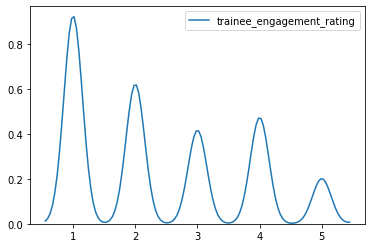

In [0]:
sns.kdeplot(train_no_na['trainee_engagement_rating'])
plt.show()

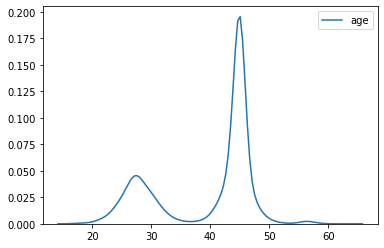

In [0]:
sns.kdeplot(train_no_na['age'])
plt.show()

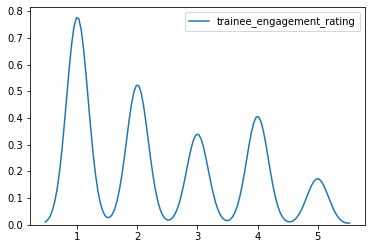

In [0]:
sns.kdeplot(test_no_na['trainee_engagement_rating'])
plt.show()

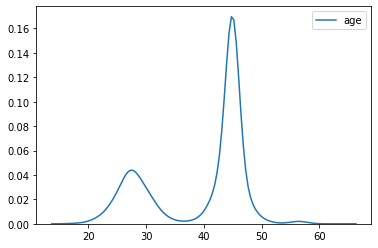

In [0]:
sns.kdeplot(test_no_na['age'])
plt.show()

In [0]:
print(train_no_na.shape,test_no_na.shape)

(73147, 16) (31349, 15)


In [0]:
train = train_no_na.copy()
test = test_no_na.copy()

# Analyzing with the target variable to get the idea 

## Program Id with is_pass

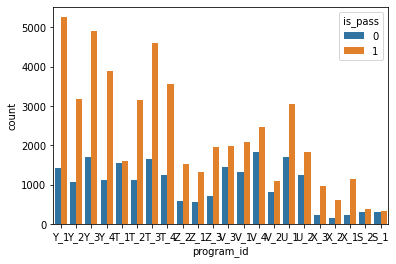

In [0]:
sns.countplot(x='program_id',hue='is_pass',data=train)
plt.show()

            Upon analysis, we can see some program ids are really having good number of pass counts. Y_1,T_3,Y_3,T_2,Y_2 are some significant program  

## Program type with is_pass

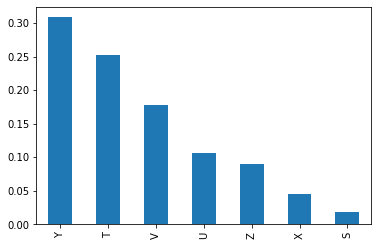

In [0]:
train['program_type'].value_counts(normalize=True).plot(kind="bar")

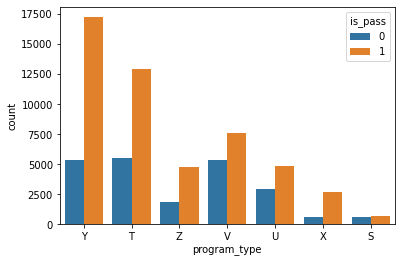

In [0]:
sns.countplot(x='program_type',hue='is_pass',data=train)
plt.show()

      Generally Y programs are having significant pass numbers then other program type

## If the number of days is more, do the pass count also increase? 

In [0]:
train['program_duration'].nunique()

10

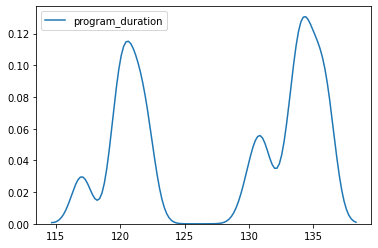

In [0]:
sns.kdeplot(train['program_duration'])
plt.show()

            From the distribution it is clear that many programs are of 120 days and 135 days

In [0]:
test['program_duration'].value_counts()

134    5608
120    4783
136    4123
121    3298
135    3268
122    3206
131    2809
117    1814
133    1447
130     993
Name: program_duration, dtype: int64

In [0]:
train['program_duration'].value_counts()

134    13027
120    11130
136     9765
121     7679
122     7374
135     7267
131     6571
117     4266
133     3409
130     2659
Name: program_duration, dtype: int64

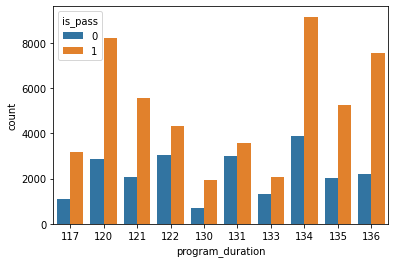

In [0]:
sns.countplot(x='program_duration',hue='is_pass',data=train)
plt.show()

            Number of duration has minimal effect on pass ... lesser number of duration and more duration has impact. Moderate durations has no impact

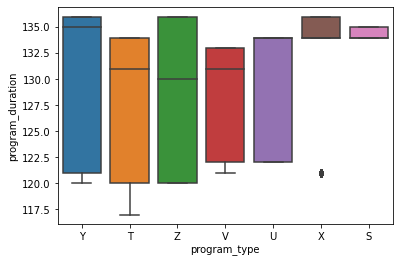

In [0]:
sns.boxplot(x="program_type",y="program_duration",data=train)
plt.show()

## Test Type with is_pass

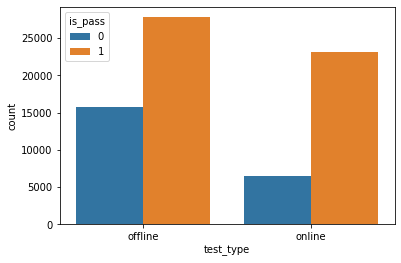

In [0]:
sns.countplot(x='test_type',hue='is_pass',data=train)
plt.show()

In [0]:
27000/(27000+15000)

0.6428571428571429

In [0]:
22500/(22500+5000)

0.8181818181818182

          more number of offline test than online test. But online test has more pass than offline (approx)

## Difficulty level with is_pass

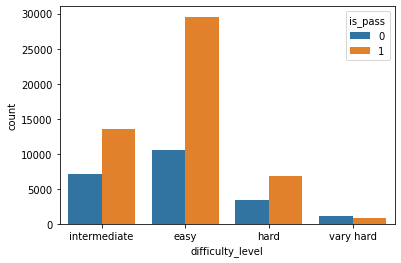

In [0]:
sns.countplot(x='difficulty_level',hue='is_pass',data=train)
plt.show()

              more easier the test is, more number of pass. It means when the test is very hard, the agent is demotivated ?

## Gender with is_pass

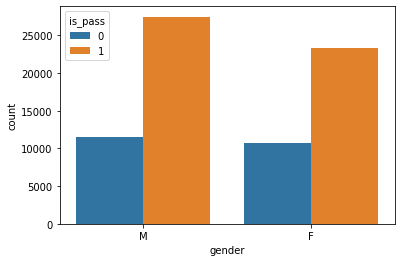

In [0]:
sns.countplot(x='gender',hue='is_pass',data=train)
plt.show()

            more male pass percentage than female

## Education level with is_pass

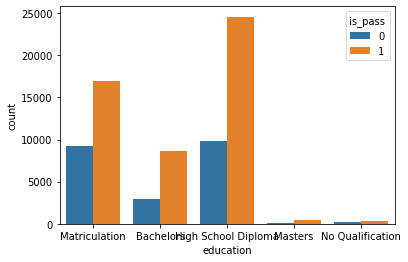

In [0]:
sns.countplot(x='education',hue='is_pass',data=train,)
plt.show()

                Diploma has more pass. But it doesnt conclude, since to become an agent, it doesnt need any good education qualifications

## ciy tier with is_pass

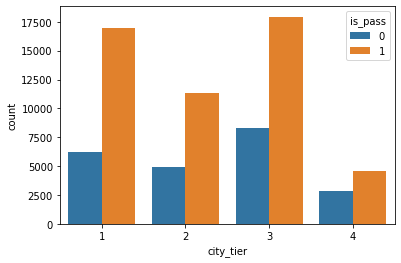

In [0]:
sns.countplot(x='city_tier',hue='is_pass',data=train,)
plt.show()

In [0]:
print("tier1",17500/(17500+6000))
print("tier2",11000/(11000+4000))
print("tier3",18000/(18000+7500))
print("tier4",4000/(4000+2500))

tier1 0.7446808510638298
tier2 0.7333333333333333
tier3 0.7058823529411765
tier4 0.6153846153846154


            Tier 1 > Tier 2 > Tier 3 > Tier 4

## Age with is_pass

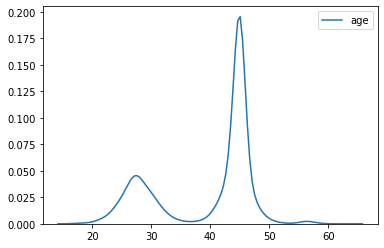

In [0]:
sns.kdeplot(train['age'])
plt.show()

In [0]:
train['age'].nunique()

45

In [0]:
train['age'].describe()

count    73147.000000
mean        39.449615
std          8.328750
min         17.000000
25%         30.000000
50%         45.000000
75%         45.000000
max         63.000000
Name: age, dtype: float64

            Divide the age based on quantiles

In [0]:
train['age_group'] = ""
train.loc[(train['age'] >= 17) & (train['age'] < 28),'age_group'] = "group 17-28"
train.loc[(train['age'] >= 28) & (train['age'] < 39),'age_group'] = "group 28-39"
train.loc[(train['age'] >= 39) & (train['age'] < 45),'age_group'] = "group 39-45"
train.loc[(train['age'] >= 45) & (train['age'] <= 63),'age_group'] = "group 45-63"

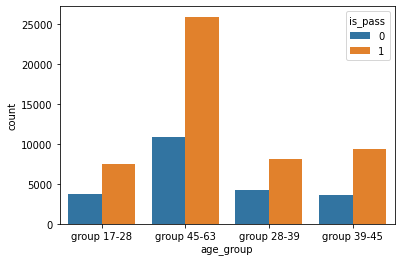

In [0]:
sns.countplot(x='age_group',hue='is_pass',data=train)
plt.show()

In [0]:
train[train['age_group'] == ""]['age']

Series([], Name: age, dtype: float64)

## Total programs enrolled with is_pass

In [0]:
train['total_programs_enrolled'].nunique()

13

In [0]:
train['program_id'].nunique()

22

In [0]:
train['total_programs_enrolled'].describe()

count    73147.000000
mean         2.583934
std          1.240816
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: total_programs_enrolled, dtype: float64

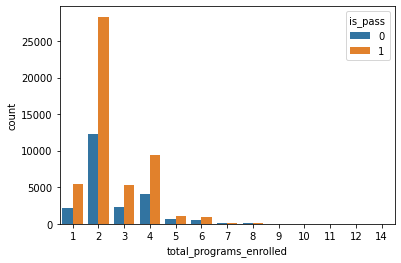

In [0]:
sns.countplot(x='total_programs_enrolled',hue='is_pass',data=train)
plt.show()

            Optimal value is 2 if the programs enrolled is 2 by trainees. pass is so high        

## Disability with is_pass

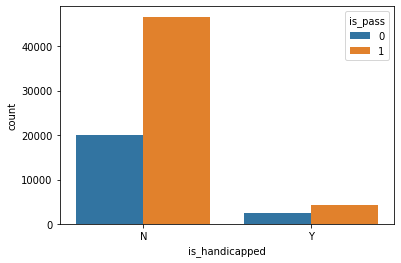

In [0]:
sns.countplot(x='is_handicapped',hue='is_pass',data=train)
plt.show()

                Most of the agents are not handicapped.             

## Trainee_engagement_rating with Is_pass

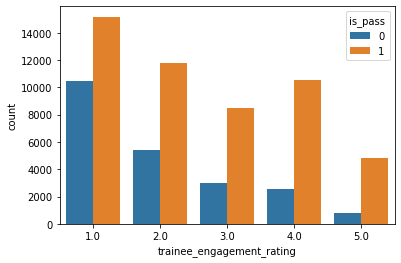

In [0]:
sns.countplot(x='trainee_engagement_rating',hue='is_pass',data=train)
plt.show()

          more the trainees engage, more number of pass

## Label encoding

In [0]:
## creating a copy
train_main = train.copy()
test_main = test.copy()

In [0]:
from sklearn.preprocessing import LabelEncoder

class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [0]:
le = LabelEncoderExt()
le.fit(train['program_id'])
train['program_id'] = le.transform(train['program_id'])
test['program_id'] = le.transform(test['program_id'])

In [0]:
le = LabelEncoderExt()
le.fit(train['program_type'])
train['program_type'] = le.transform(train['program_type'])
test['program_type'] = le.transform(test['program_type'])

le = LabelEncoderExt()
le.fit(train['test_type'])
train['test_type'] = le.transform(train['test_type'])
test['test_type'] = le.transform(test['test_type'])

le = LabelEncoderExt()
le.fit(train['difficulty_level'])
train['difficulty_level'] = le.transform(train['difficulty_level'])
test['difficulty_level'] = le.transform(test['difficulty_level'])

le = LabelEncoderExt()
le.fit(train['gender'])
train['gender'] = le.transform(train['gender'])
test['gender'] = le.transform(test['gender'])

le = LabelEncoderExt()
le.fit(train['education'])
train['education'] = le.transform(train['education'])
test['education'] = le.transform(test['education'])

le = LabelEncoderExt()
le.fit(train['is_handicapped'])
train['is_handicapped'] = le.transform(train['is_handicapped'])
test['is_handicapped'] = le.transform(test['is_handicapped'])

# Baseline model

In [0]:
train.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group
0,9389_150,16,6,136,150,1,3,9389,1,3,3,24.0,5,0,1.0,0,group 17-28
6,17874_144,17,6,120,144,2,1,17874,1,0,2,48.0,3,0,3.0,1,group 45-63
9,17019_153,16,6,136,153,1,2,17019,1,0,3,28.0,2,0,4.0,1,group 28-39
12,15848_149,16,6,136,149,1,3,15848,1,1,1,45.0,4,0,4.0,1,group 45-63
13,423_126,18,6,135,126,1,3,423,1,3,3,45.0,4,0,5.0,1,group 45-63


In [0]:
df_majority = train[train.is_pass==1]
df_minority = train[train.is_pass==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=50867,    # to match majority class
                                 random_state=88) # reproducible results
 
# Combine majority class with upsampled minority class
train = pd.concat([df_majority, df_minority_upsampled])

In [0]:
train['is_pass'].value_counts()

1    50867
0    50867
Name: is_pass, dtype: int64

In [0]:
X = train[['program_id','program_duration','test_type','difficulty_level','test_id','trainee_id',
           'gender','education','city_tier','age','total_programs_enrolled','is_handicapped',
           'trainee_engagement_rating']]
y = train['is_pass']

In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, 
                                                      random_state=88,test_size=0.20, stratify=y)

In [0]:
lr = LogisticRegression()
lr.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  w0, loss = opt_res.x, opt_res.fun


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = lr.predict(x_valid)

In [0]:
def evaluate_model(y_true, y_pred):
    print('confusion matrix')
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm.T)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)
    print('classification report')
    print(classification_report(y_true,y_pred))
    print('accuracy score')
    print(accuracy_score(y_true, y_pred))

In [0]:
evaluate_model(y_valid,y_pred)

confusion matrix
True          0     1
Predicted            
0          6712  4282
1          3462  5891
classification report
              precision    recall  f1-score   support

           0       0.61      0.66      0.63     10174
           1       0.63      0.58      0.60     10173

    accuracy                           0.62     20347
   macro avg       0.62      0.62      0.62     20347
weighted avg       0.62      0.62      0.62     20347

accuracy score
0.6194033518454809


In [0]:
X_test = test[['program_id','program_duration','test_type','difficulty_level','test_id','trainee_id',
           'gender','education','city_tier','age','total_programs_enrolled','is_handicapped',
           'trainee_engagement_rating']]

In [0]:
y_test = lr.predict(X_test)

In [0]:
ispass_df = pd.DataFrame(y_test,columns = ["is_pass"])

In [0]:
submission = pd.concat([test,ispass_df],axis=1)
submission = submission[['id','is_pass']]
submission.to_csv("submission_baseline.csv",index=False)

          Above file acts as a baseline that resulted in 0.509

# Analysis

In [0]:
train_main.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28
6,17874_144,Y_2,Y,120,144,online,easy,17874,M,Bachelors,2,48.0,3,N,3.0,1,group 45-63
9,17019_153,Y_1,Y,136,153,offline,hard,17019,M,Bachelors,3,28.0,2,N,4.0,1,group 28-39
12,15848_149,Y_1,Y,136,149,offline,intermediate,15848,M,High School Diploma,1,45.0,4,N,4.0,1,group 45-63
13,423_126,Y_3,Y,135,126,offline,intermediate,423,M,Matriculation,3,45.0,4,N,5.0,1,group 45-63


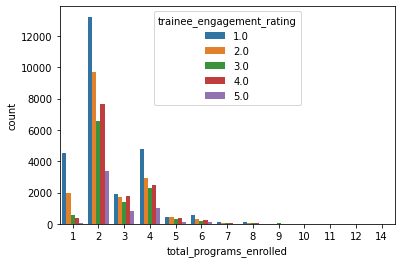

In [0]:
sns.countplot("total_programs_enrolled",hue="trainee_engagement_rating",data=train_main)
plt.show()

In [0]:
train_main['education'].value_counts()

High School Diploma    34371
Matriculation          26169
Bachelors              11581
No Qualification         514
Masters                  512
Name: education, dtype: int64

# Pycaret demo

In [0]:
train_main_pycaret = train_main.drop(columns = ["age_group"]).copy()
test_main_pycaret = test_main.copy()

In [0]:
train_main_pycaret['is_pass'].value_counts()

1    50867
0    22280
Name: is_pass, dtype: int64

In [0]:
df_majority = train_main_pycaret[train_main_pycaret.is_pass==1]
df_minority = train_main_pycaret[train_main_pycaret.is_pass==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=50867,    # to match majority class
                                 random_state=88) # reproducible results
 
# Combine majority class with upsampled minority class
train_main_pycaret_sampled = pd.concat([df_majority, df_minority_upsampled])

In [0]:
df_minority_upsampled.shape

(50867, 16)

In [0]:
train_main_pycaret_sampled['is_pass'].value_counts()

1    50867
0    50867
Name: is_pass, dtype: int64

In [0]:
train_main_pycaret_sampled['program_duration'] = train_main_pycaret_sampled['program_duration'].astype(float)
test_main_pycaret['program_duration'] = test_main_pycaret['program_duration'].astype(float)
train_main_pycaret_sampled['total_programs_enrolled'] = train_main_pycaret_sampled['total_programs_enrolled'].astype(float)
test_main_pycaret['total_programs_enrolled'] = test_main_pycaret['total_programs_enrolled'].astype(float)

In [0]:
clf1 = setup(data = train_main_pycaret_sampled, target = 'is_pass')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,2239
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(101734, 16)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,8
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [0]:
# compare_models()

In [0]:
extra_tree = create_model("et")

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8012,0.9063,0.7553,0.8317,0.7917,0.6024
1,0.7974,0.9003,0.7581,0.8228,0.7891,0.5948
2,0.8110,0.9038,0.7770,0.8338,0.8044,0.6221
3,0.8056,0.9072,0.7625,0.8345,0.7969,0.6112
4,0.8036,0.8994,0.7633,0.8303,0.7954,0.6072
5,0.8100,0.9053,0.7673,0.8390,0.8015,0.6201
6,0.8026,0.8993,0.7705,0.8233,0.7960,0.6052
7,0.8038,0.9042,0.7709,0.8252,0.7971,0.6076
8,0.8018,0.8962,0.7665,0.8247,0.7945,0.6036
9,0.8038,0.8992,0.7725,0.8241,0.7974,0.6075


In [0]:
y_pred = predict_model(extra_tree,data=test_main_pycaret)

In [0]:
y_pred.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,Label,Score
0,1626_45,T_1,T,131.0,45,offline,intermediate,1626,F,Matriculation,3,46.0,2.0,N,4.0,1,0.75
1,5499_29,T_3,T,134.0,29,online,easy,5499,F,High School Diploma,2,45.0,2.0,N,4.0,1,0.88
2,6215_17,T_4,T,120.0,17,online,easy,6215,F,High School Diploma,1,45.0,4.0,N,1.0,1,0.87
3,11094_23,T_3,T,134.0,23,offline,intermediate,11094,F,Bachelors,2,44.0,2.0,N,1.0,0,0.31
4,17853_11,T_4,T,120.0,11,offline,intermediate,17853,F,Matriculation,1,48.0,2.0,N,3.0,1,0.87


In [0]:
y_pred['Label'].value_counts()

1    21214
0    10135
Name: Label, dtype: int64

In [0]:
submission_pycaret_test = y_pred[['id','Label']]
submission_pycaret_test.rename(columns={"Label":'is_pass'},inplace=True)
submission_pycaret_test.to_csv("submission_et_pycaret_v1.csv",index=False)

              The above code resulted in 0.629 accuracy. Atleast we can try using lightgbm to improve the accuracy. Awesome pycaret. It can be mainly used for initial analysis

# Further analysis after baseline model and boosting model

In [0]:
train_analysis = train_main.copy()
test_analysis = test_main.copy()

In [0]:
train_analysis.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28
6,17874_144,Y_2,Y,120,144,online,easy,17874,M,Bachelors,2,48.0,3,N,3.0,1,group 45-63
9,17019_153,Y_1,Y,136,153,offline,hard,17019,M,Bachelors,3,28.0,2,N,4.0,1,group 28-39
12,15848_149,Y_1,Y,136,149,offline,intermediate,15848,M,High School Diploma,1,45.0,4,N,4.0,1,group 45-63
13,423_126,Y_3,Y,135,126,offline,intermediate,423,M,Matriculation,3,45.0,4,N,5.0,1,group 45-63


In [0]:
train_analysis['test_id'].nunique()

188

In [0]:
train_analysis['program_duration'].describe()

count    73147.000000
mean       128.208676
std          6.889679
min        117.000000
25%        121.000000
50%        131.000000
75%        134.000000
max        136.000000
Name: program_duration, dtype: float64

In [0]:
# def z_norm(x,mean,sd):
#   return (x-mean)/sd

# mean_duration = train['program_duration'].mean()
# std_duration = train['program_duration'].std()
# mean_age = train['age'].mean()
# std_age = train['age'].std()

# train['program_duration'] = train['program_duration'].apply(z_norm,mean=mean_duration,sd=std_duration)
# train['age'] = train['age'].apply(z_norm,mean=mean_age,sd=std_age)

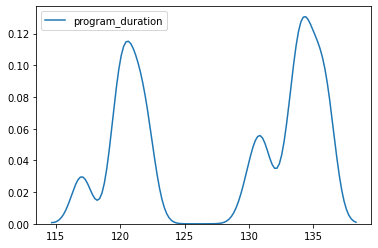

In [0]:
sns.kdeplot(train_analysis['program_duration'])
plt.show()

In [0]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

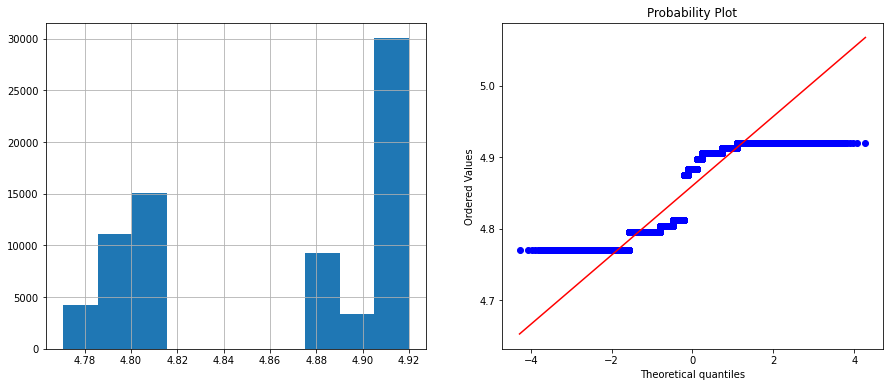

In [0]:
train_analysis['program_duration_log'] = np.log(train_analysis.program_duration +1)
diagnostic_plots(train_analysis,'program_duration_log')

In [0]:
train_analysis.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group,program_duration_log
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28,4.919981
6,17874_144,Y_2,Y,120,144,online,easy,17874,M,Bachelors,2,48.0,3,N,3.0,1,group 45-63,4.795791
9,17019_153,Y_1,Y,136,153,offline,hard,17019,M,Bachelors,3,28.0,2,N,4.0,1,group 28-39,4.919981
12,15848_149,Y_1,Y,136,149,offline,intermediate,15848,M,High School Diploma,1,45.0,4,N,4.0,1,group 45-63,4.919981
13,423_126,Y_3,Y,135,126,offline,intermediate,423,M,Matriculation,3,45.0,4,N,5.0,1,group 45-63,4.912655


In [0]:
# Creating feature that includes education and tier as it is my intuition that same qualification from tier 1 city is much more effective than tier 2 and so on
train_analysis['education_tier'] = train_analysis['city_tier'].map(str) + "_" + train_analysis['education'] 
test_analysis['education_tier'] = test_analysis['city_tier'].map(str) + "_" + test_analysis['education'] 

In [0]:
train_analysis.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group,program_duration_log,education_tier
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28,4.919981,3_Matriculation
6,17874_144,Y_2,Y,120,144,online,easy,17874,M,Bachelors,2,48.0,3,N,3.0,1,group 45-63,4.795791,2_Bachelors
9,17019_153,Y_1,Y,136,153,offline,hard,17019,M,Bachelors,3,28.0,2,N,4.0,1,group 28-39,4.919981,3_Bachelors
12,15848_149,Y_1,Y,136,149,offline,intermediate,15848,M,High School Diploma,1,45.0,4,N,4.0,1,group 45-63,4.919981,1_High School Diploma
13,423_126,Y_3,Y,135,126,offline,intermediate,423,M,Matriculation,3,45.0,4,N,5.0,1,group 45-63,4.912655,3_Matriculation


In [0]:
train_analysis['program_duration'].describe()

count    73147.000000
mean       128.208676
std          6.889679
min        117.000000
25%        121.000000
50%        131.000000
75%        134.000000
max        136.000000
Name: program_duration, dtype: float64

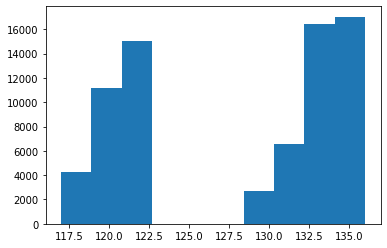

In [0]:
plt.hist(train_analysis['program_duration'])
plt.show()

In [0]:
## We will try to make the program duration into categorical by splitting into 4
def program_duration_cat(df,variable):
  min_value = df[variable].describe()['min']
  per_25 = df[variable].describe()['25%']
  per_50 = df[variable].describe()['50%']
  per_75 = df[variable].describe()['75%']
  max_value = df[variable].describe()['max']
  df['program_duration_cat'] = ""
  df.loc[((df[variable] >= min_value) & (df[variable] <= per_25)),'program_duration_cat'] = "Minimum duration"
  df.loc[((df[variable] > per_25) & (df[variable] <= per_50)),'program_duration_cat'] = "medium1 duration"
  df.loc[((df[variable] > per_50) & (df[variable] <= per_75)),'program_duration_cat'] = "medium2 duration"
  df.loc[((df[variable] > per_75) & (df[variable] <= max_value)),'program_duration_cat'] = "max duration"
  return df['program_duration_cat']

In [0]:
train_analysis['program_duration_cat'] = program_duration_cat(train_analysis,'program_duration')
test_analysis['program_duration_cat'] = program_duration_cat(test_analysis,'program_duration')

In [0]:
train_analysis['program_duration_cat'].value_counts()

Minimum duration    23075
max duration        17032
medium1 duration    16604
medium2 duration    16436
Name: program_duration_cat, dtype: int64

In [0]:
test_analysis['program_duration_cat'].value_counts()

Minimum duration    9895
max duration        7391
medium2 duration    7055
medium1 duration    7008
Name: program_duration_cat, dtype: int64

In [0]:
train_analysis.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group,program_duration_log,education_tier,program_duration_cat
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28,4.919981,3_Matriculation,max duration
6,17874_144,Y_2,Y,120,144,online,easy,17874,M,Bachelors,2,48.0,3,N,3.0,1,group 45-63,4.795791,2_Bachelors,Minimum duration
9,17019_153,Y_1,Y,136,153,offline,hard,17019,M,Bachelors,3,28.0,2,N,4.0,1,group 28-39,4.919981,3_Bachelors,max duration
12,15848_149,Y_1,Y,136,149,offline,intermediate,15848,M,High School Diploma,1,45.0,4,N,4.0,1,group 45-63,4.919981,1_High School Diploma,max duration
13,423_126,Y_3,Y,135,126,offline,intermediate,423,M,Matriculation,3,45.0,4,N,5.0,1,group 45-63,4.912655,3_Matriculation,max duration


In [0]:
test_analysis['age'].describe()

count    31349.000000
mean        39.400651
std          8.358654
min         17.000000
25%         30.000000
50%         45.000000
75%         45.000000
max         63.000000
Name: age, dtype: float64

In [0]:
test_analysis['age_group'] = ""
test_analysis.loc[(test_analysis['age'] >= 17) & (test_analysis['age'] < 28),'age_group'] = "group 17-28"
test_analysis.loc[(test_analysis['age'] >= 28) & (test_analysis['age'] < 39),'age_group'] = "group 28-39"
test_analysis.loc[(test_analysis['age'] >= 39) & (test_analysis['age'] < 45),'age_group'] = "group 39-45"
test_analysis.loc[(test_analysis['age'] >= 45) & (test_analysis['age'] <= 63),'age_group'] = "group 45-63"

In [0]:
def experience(df,variable):
  df['experience'] = ""
  df.loc[df[variable] == 'group 17-28','experience'] = "Least experience"
  df.loc[df[variable] == 'group 28-39','experience'] = "Moderate experience"
  df.loc[df[variable] == 'group 39-45','experience'] = "Experienced"
  df.loc[df[variable] == 'group 45-63','experience'] = "Highly experienced"
  return df['experience']

In [0]:
train_analysis['experience'] = experience(train_analysis,'age_group')
test_analysis['experience'] = experience(test_analysis,'age_group')

In [0]:
train_analysis.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group,program_duration_log,education_tier,program_duration_cat,experience
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28,4.919981,3_Matriculation,max duration,Least experience
6,17874_144,Y_2,Y,120,144,online,easy,17874,M,Bachelors,2,48.0,3,N,3.0,1,group 45-63,4.795791,2_Bachelors,Minimum duration,Highly experienced
9,17019_153,Y_1,Y,136,153,offline,hard,17019,M,Bachelors,3,28.0,2,N,4.0,1,group 28-39,4.919981,3_Bachelors,max duration,Moderate experience
12,15848_149,Y_1,Y,136,149,offline,intermediate,15848,M,High School Diploma,1,45.0,4,N,4.0,1,group 45-63,4.919981,1_High School Diploma,max duration,Highly experienced
13,423_126,Y_3,Y,135,126,offline,intermediate,423,M,Matriculation,3,45.0,4,N,5.0,1,group 45-63,4.912655,3_Matriculation,max duration,Highly experienced


In [0]:
for program_id in train_analysis['program_id'].unique():
  print(train_analysis[train_analysis['program_id'] == program_id]['test_type'].value_counts())
  print("---------------------------")

online     3692
offline    2995
Name: test_type, dtype: int64
---------------------------
online     2333
offline    1908
Name: test_type, dtype: int64
---------------------------
online     3572
offline    3051
Name: test_type, dtype: int64
---------------------------
online     2758
offline    2251
Name: test_type, dtype: int64
---------------------------
offline    3152
Name: test_type, dtype: int64
---------------------------
offline    2337
online     1929
Name: test_type, dtype: int64
---------------------------
offline    3450
online     2798
Name: test_type, dtype: int64
---------------------------
offline    2591
online     2201
Name: test_type, dtype: int64
---------------------------
online     1301
offline     796
Name: test_type, dtype: int64
---------------------------
online     1167
offline     706
Name: test_type, dtype: int64
---------------------------
online     1681
offline     978
Name: test_type, dtype: int64
---------------------------
offline    3419
Name: test

In [0]:
for program_id in train_analysis['program_id'].unique():
  print(program_id)
  print(train_analysis[train_analysis['program_id'] == program_id]['difficulty_level'].value_counts())
  print("---------------------------")

Y_1
easy            3692
hard            1521
intermediate    1474
Name: difficulty_level, dtype: int64
---------------------------
Y_2
easy            2333
hard             992
intermediate     916
Name: difficulty_level, dtype: int64
---------------------------
Y_3
easy            3572
hard            1603
intermediate    1448
Name: difficulty_level, dtype: int64
---------------------------
Y_4
easy            2758
hard            1140
intermediate    1111
Name: difficulty_level, dtype: int64
---------------------------
T_1
easy            1415
hard            1131
intermediate     606
Name: difficulty_level, dtype: int64
---------------------------
T_2
easy            2425
intermediate    1841
Name: difficulty_level, dtype: int64
---------------------------
T_3
easy            3545
intermediate    2703
Name: difficulty_level, dtype: int64
---------------------------
T_4
easy            2761
intermediate    2031
Name: difficulty_level, dtype: int64
---------------------------
Z_2
eas

In [0]:
for program_type in train_analysis['program_type'].unique():
  print(program_type)
  print(train_analysis[train_analysis['program_type'] == program_type]['test_type'].value_counts())
  print("---------------------------")

Y
online     12355
offline    10205
Name: test_type, dtype: int64
---------------------------
T
offline    11530
online      6928
Name: test_type, dtype: int64
---------------------------
Z
online     4149
offline    2480
Name: test_type, dtype: int64
---------------------------
V
offline    10818
online      2207
Name: test_type, dtype: int64
---------------------------
U
online     3965
offline    3856
Name: test_type, dtype: int64
---------------------------
X
offline    3328
Name: test_type, dtype: int64
---------------------------
S
offline    1326
Name: test_type, dtype: int64
---------------------------


In [0]:
train_analysis['difficulty_test_type'] = train_analysis['difficulty_level'] +"_"+ train_analysis['test_type']
test_analysis['difficulty_test_type'] = test_analysis['difficulty_level'] +"_"+ test_analysis['test_type']

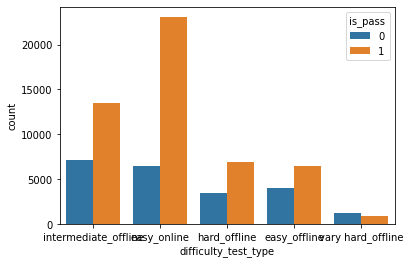

In [0]:
sns.countplot(x='difficulty_test_type',hue='is_pass',data=train_analysis)
plt.xticks()
plt.show()

In [0]:
train_analysis.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group,program_duration_log,education_tier,program_duration_cat,experience,difficulty_test_type
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28,4.919981,3_Matriculation,max duration,Least experience,intermediate_offline
6,17874_144,Y_2,Y,120,144,online,easy,17874,M,Bachelors,2,48.0,3,N,3.0,1,group 45-63,4.795791,2_Bachelors,Minimum duration,Highly experienced,easy_online
9,17019_153,Y_1,Y,136,153,offline,hard,17019,M,Bachelors,3,28.0,2,N,4.0,1,group 28-39,4.919981,3_Bachelors,max duration,Moderate experience,hard_offline
12,15848_149,Y_1,Y,136,149,offline,intermediate,15848,M,High School Diploma,1,45.0,4,N,4.0,1,group 45-63,4.919981,1_High School Diploma,max duration,Highly experienced,intermediate_offline
13,423_126,Y_3,Y,135,126,offline,intermediate,423,M,Matriculation,3,45.0,4,N,5.0,1,group 45-63,4.912655,3_Matriculation,max duration,Highly experienced,intermediate_offline


In [0]:
test_analysis[test_analysis['trainee_id'] ==9389]

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,education_tier,program_duration_cat,age_group,experience,difficulty_test_type
3836,9389_149,Y_1,Y,136,149,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,3_Matriculation,max duration,group 17-28,Least experience,intermediate_offline
27224,9389_151,Y_1,Y,136,151,offline,hard,9389,M,Matriculation,3,24.0,5,N,1.0,3_Matriculation,max duration,group 17-28,Least experience,hard_offline


In [0]:
train_analysis[train_analysis['trainee_id'] ==9389]

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group,program_duration_log,education_tier,program_duration_cat,experience,difficulty_test_type
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28,4.919981,3_Matriculation,max duration,Least experience,intermediate_offline
49948,9389_154,Y_1,Y,136,154,online,easy,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28,4.919981,3_Matriculation,max duration,Least experience,easy_online
64716,9389_152,Y_1,Y,136,152,offline,hard,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28,4.919981,3_Matriculation,max duration,Least experience,hard_offline


In [0]:
train_analysis['total_programs_enrolled'].value_counts()

2     40538
4     13521
3      7652
1      7522
5      1705
6      1458
8       300
7       286
9        79
10       30
12       28
11       15
14       13
Name: total_programs_enrolled, dtype: int64

In [0]:
train_analysis['total_programs_enrolled'].describe()

count    73147.000000
mean         2.583934
std          1.240816
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: total_programs_enrolled, dtype: float64

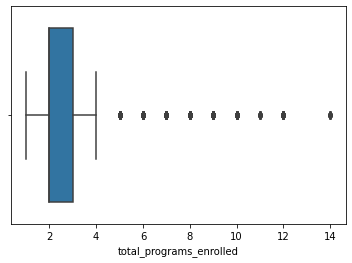

In [0]:
sns.boxplot(x=train_analysis['total_programs_enrolled'])

In [0]:
## To find the characteristics of total programs enrolled
for i in range(1,15,1):
  print(i)
  print(train_analysis[train_analysis['total_programs_enrolled'] == i]['is_pass'].value_counts("normalize"))
  print("-----------------------")

1
1    0.717229
0    0.282771
Name: is_pass, dtype: float64
-----------------------
2
1    0.698209
0    0.301791
Name: is_pass, dtype: float64
-----------------------
3
1    0.693936
0    0.306064
Name: is_pass, dtype: float64
-----------------------
4
1    0.695141
0    0.304859
Name: is_pass, dtype: float64
-----------------------
5
1    0.628152
0    0.371848
Name: is_pass, dtype: float64
-----------------------
6
1    0.645405
0    0.354595
Name: is_pass, dtype: float64
-----------------------
7
1    0.646853
0    0.353147
Name: is_pass, dtype: float64
-----------------------
8
1    0.603333
0    0.396667
Name: is_pass, dtype: float64
-----------------------
9
0    0.582278
1    0.417722
Name: is_pass, dtype: float64
-----------------------
10
1    0.7
0    0.3
Name: is_pass, dtype: float64
-----------------------
11
1    0.6
0    0.4
Name: is_pass, dtype: float64
-----------------------
12
0    0.678571
1    0.321429
Name: is_pass, dtype: float64
-----------------------
13
Series

          There is no big change in behavior of is_pass irrespective of total programs enrolled

In [0]:
## Splitting enrolled into quantiles
## Total Enrolled - 1 (25%) or 50%
## Total Enrolled - 2 (75%)
## Total Enrolled - 3 (100%)

In [0]:
train_analysis['total_programs_enrolled'].describe()

count    73147.000000
mean         2.583934
std          1.240816
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: total_programs_enrolled, dtype: float64

In [0]:
def total_programs_enrolled_cat(df,variable):
  df['total_programs_enrolled_cat'] = ""
  df.loc[((df[variable] >= 1) & (df[variable] <= 2)),'total_programs_enrolled_cat'] = "Total Enrolled - 1"
  df.loc[((df[variable] > 2) & (df[variable] <= 3)),'total_programs_enrolled_cat'] = "Total Enrolled - 2"
  df.loc[((df[variable] > 3) & (df[variable] <= 14)),'total_programs_enrolled_cat'] = "Total Enrolled - 3"
  return df['total_programs_enrolled_cat']

In [0]:
train_analysis['total_programs_enrolled_cat'] = total_programs_enrolled_cat(train_analysis,'total_programs_enrolled')
test_analysis['total_programs_enrolled_cat'] = total_programs_enrolled_cat(test_analysis,'total_programs_enrolled')

In [0]:
train_analysis.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group,program_duration_log,education_tier,program_duration_cat,experience,difficulty_test_type,total_programs_enrolled_cat
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28,4.919981,3_Matriculation,max duration,Least experience,intermediate_offline,Total Enrolled - 3
6,17874_144,Y_2,Y,120,144,online,easy,17874,M,Bachelors,2,48.0,3,N,3.0,1,group 45-63,4.795791,2_Bachelors,Minimum duration,Highly experienced,easy_online,Total Enrolled - 2
9,17019_153,Y_1,Y,136,153,offline,hard,17019,M,Bachelors,3,28.0,2,N,4.0,1,group 28-39,4.919981,3_Bachelors,max duration,Moderate experience,hard_offline,Total Enrolled - 1
12,15848_149,Y_1,Y,136,149,offline,intermediate,15848,M,High School Diploma,1,45.0,4,N,4.0,1,group 45-63,4.919981,1_High School Diploma,max duration,Highly experienced,intermediate_offline,Total Enrolled - 3
13,423_126,Y_3,Y,135,126,offline,intermediate,423,M,Matriculation,3,45.0,4,N,5.0,1,group 45-63,4.912655,3_Matriculation,max duration,Highly experienced,intermediate_offline,Total Enrolled - 3


In [0]:
train_analysis.loc[((train_analysis['total_programs_enrolled'] >= 1) & (train_analysis['total_programs_enrolled'] <= 2)),'total_programs_enrolled_cat'] = "Total Enrolled - 1"

In [0]:
train_analysis[((train_analysis['total_programs_enrolled'] >= 1) & (train_analysis['total_programs_enrolled'] <= 2))]['total_programs_enrolled_cat']

9        Total Enrolled - 1
19       Total Enrolled - 1
20       Total Enrolled - 1
23       Total Enrolled - 1
34       Total Enrolled - 1
                ...        
72931    Total Enrolled - 1
72941    Total Enrolled - 1
72962    Total Enrolled - 1
73004    Total Enrolled - 1
73037    Total Enrolled - 1
Name: total_programs_enrolled_cat, Length: 48060, dtype: object

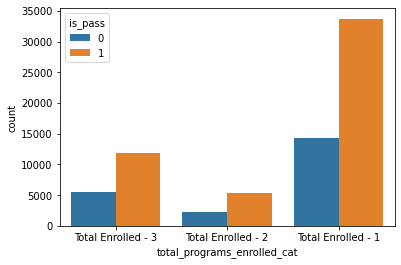

In [0]:
sns.countplot(x="total_programs_enrolled_cat",hue="is_pass",data=train_analysis)
plt.show()

In [0]:
## To find the characteristics of total programs enrolled
for value in train_analysis['total_programs_enrolled_cat'].unique():

  print(train_analysis[train_analysis['total_programs_enrolled_cat'] == value]['is_pass'].value_counts("normalize"))
  print("-----------------------")

1    0.680126
0    0.319874
Name: is_pass, dtype: float64
-----------------------
1    0.693936
0    0.306064
Name: is_pass, dtype: float64
-----------------------
1    0.701186
0    0.298814
Name: is_pass, dtype: float64
-----------------------


            same pattern and same proportion throughout

# Pycaret after feature engineering

In [0]:
train_analysis.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group,program_duration_log,education_tier,program_duration_cat,experience,difficulty_test_type,total_programs_enrolled_cat
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28,4.919981,3_Matriculation,max duration,Least experience,intermediate_offline,Total Enrolled - 3
6,17874_144,Y_2,Y,120,144,online,easy,17874,M,Bachelors,2,48.0,3,N,3.0,1,group 45-63,4.795791,2_Bachelors,Minimum duration,Highly experienced,easy_online,Total Enrolled - 2
9,17019_153,Y_1,Y,136,153,offline,hard,17019,M,Bachelors,3,28.0,2,N,4.0,1,group 28-39,4.919981,3_Bachelors,max duration,Moderate experience,hard_offline,Total Enrolled - 1
12,15848_149,Y_1,Y,136,149,offline,intermediate,15848,M,High School Diploma,1,45.0,4,N,4.0,1,group 45-63,4.919981,1_High School Diploma,max duration,Highly experienced,intermediate_offline,Total Enrolled - 3
13,423_126,Y_3,Y,135,126,offline,intermediate,423,M,Matriculation,3,45.0,4,N,5.0,1,group 45-63,4.912655,3_Matriculation,max duration,Highly experienced,intermediate_offline,Total Enrolled - 3


In [0]:
train_analysis_pycaret = train_analysis[['id','program_id','test_id','trainee_id','program_type','program_duration','age','difficulty_test_type','total_programs_enrolled',
                                         'gender','education_tier','is_handicapped','trainee_engagement_rating','is_pass']]
test_analysis_pycaret = test_analysis[['id','program_id','test_id','trainee_id','program_type','program_duration','age','difficulty_test_type','total_programs_enrolled',
                                         'gender','education_tier','is_handicapped','trainee_engagement_rating']]

In [0]:
df_majority = train_analysis_pycaret[train_analysis_pycaret.is_pass==1]
df_minority = train_analysis_pycaret[train_analysis_pycaret.is_pass==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=50867,    # to match majority class
                                 random_state=88) # reproducible results
 
# Combine majority class with upsampled minority class
train_analysis_pycaret_sampled = pd.concat([df_majority, df_minority_upsampled])

In [0]:
df_minority_upsampled.shape

(50867, 14)

In [0]:
train_analysis_pycaret_sampled['is_pass'].value_counts()

1    50867
0    50867
Name: is_pass, dtype: int64

In [0]:
train_analysis_pycaret_sampled.dtypes

id                            object
program_id                    object
test_id                        int64
trainee_id                     int64
program_type                  object
program_duration               int64
age                          float64
difficulty_test_type          object
total_programs_enrolled        int64
gender                        object
education_tier                object
is_handicapped                object
trainee_engagement_rating    float64
is_pass                        int64
dtype: object

In [0]:
train_analysis_pycaret_sampled['program_duration'] = train_analysis_pycaret_sampled['program_duration'].astype(float)
test_main_pycaret['program_duration'] = test_main_pycaret['program_duration'].astype(float)
train_analysis_pycaret_sampled['total_programs_enrolled'] = train_analysis_pycaret_sampled['total_programs_enrolled'].astype(float)
test_main_pycaret['total_programs_enrolled'] = test_main_pycaret['total_programs_enrolled'].astype(float)

In [0]:
clf2 = setup(data = train_analysis_pycaret_sampled, target = 'is_pass')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,4165
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(101734, 14)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,6
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [0]:
# compare_models()

In [0]:
et_new = create_model("et")

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8054,0.8998,0.7693,0.8292,0.7981,0.6108
1,0.8118,0.9032,0.7845,0.8298,0.8065,0.6237
2,0.8074,0.9096,0.7556,0.8429,0.7969,0.6148
3,0.7934,0.8976,0.7552,0.8175,0.7851,0.5868
4,0.7980,0.9018,0.7557,0.8256,0.7891,0.5960
5,0.8078,0.9010,0.7758,0.8290,0.8015,0.6157
6,0.8030,0.9018,0.7673,0.8263,0.7958,0.6060
7,0.8066,0.9034,0.7762,0.8266,0.8006,0.6132
8,0.7916,0.8953,0.7545,0.8150,0.7836,0.5832
9,0.8016,0.9020,0.7632,0.8266,0.7937,0.6031


In [0]:
# randomForest = create_model('rf')
# catboost = create_model('catboost')
# xgboost = create_model('xgboost')
# decision = create_model('dt')


In [0]:
# blender = blend_models(estimator_list = [randomForest,et_new,xgboost,decision])

In [0]:
# y_analysis_pycaret_stack = predict_model(stacker,data=test_analysis_pycaret)

In [0]:
y_analysis_pycaret = predict_model(et_new,data=test_analysis_pycaret)

In [0]:
# submission_new = y_analysis_pycaret_stack[['id','Label']]
# submission_new.rename(columns={"Label":"is_pass"},inplace=True)
# submission_new.to_csv("submission_new_v3.csv",index=False)

In [0]:
submission_new = y_analysis_pycaret[['id','Label']]
submission_new.rename(columns={"Label":"is_pass"},inplace=True)
submission_new.to_csv("submission_new_v2.csv",index=False)

## Label encode features

In [0]:
train_analysis.columns

Index(['id', 'program_id', 'program_type', 'program_duration', 'test_id',
       'test_type', 'difficulty_level', 'trainee_id', 'gender', 'education',
       'city_tier', 'age', 'total_programs_enrolled', 'is_handicapped',
       'trainee_engagement_rating', 'is_pass', 'age_group',
       'program_duration_log', 'education_tier', 'program_duration_cat',
       'experience', 'difficulty_test_type', 'total_programs_enrolled_cat'],
      dtype='object')

In [0]:
train_analysis_pycaret = train_analysis[['id','program_id','test_id','trainee_id','program_duration_cat','age','difficulty_test_type','total_programs_enrolled',
                                         'gender','education_tier','is_handicapped','trainee_engagement_rating','is_pass']]
test_analysis_pycaret = test_analysis[['id','program_id','test_id','trainee_id','program_duration_cat','age','difficulty_test_type','total_programs_enrolled',
                                         'gender','education_tier','is_handicapped','trainee_engagement_rating']]

In [0]:
le = LabelEncoderExt()
le.fit(train_analysis_pycaret['program_id'])
train_analysis_pycaret['program_id'] = le.transform(train_analysis_pycaret['program_id'])
test_analysis_pycaret['program_id'] = le.transform(test_analysis_pycaret['program_id'])

# le = LabelEncoderExt()
# le.fit(train_analysis_pycaret['program_type'])
# train_analysis_pycaret['program_type'] = le.transform(train_analysis_pycaret['program_type'])
# test_analysis_pycaret['program_type'] = le.transform(test_analysis_pycaret['program_type'])

le = LabelEncoderExt()
le.fit(train_analysis_pycaret['difficulty_test_type'])
train_analysis_pycaret['difficulty_test_type'] = le.transform(train_analysis_pycaret['difficulty_test_type'])
test_analysis_pycaret['difficulty_test_type'] = le.transform(test_analysis_pycaret['difficulty_test_type'])

# le = LabelEncoderExt()
# le.fit(train_analysis_pycaret['difficulty_level'])
# train_analysis_pycaret['difficulty_level'] = le.transform(train_analysis_pycaret['difficulty_level'])
# test_analysis_pycaret['difficulty_level'] = le.transform(test_analysis_pycaret['difficulty_level'])

# le = LabelEncoderExt()
# le.fit(train_analysis_pycaret['test_type'])
# train_analysis_pycaret['test_type'] = le.transform(train_analysis_pycaret['test_type'])
# test_analysis_pycaret['test_type'] = le.transform(test_analysis_pycaret['test_type'])

le = LabelEncoderExt()
le.fit(train_analysis_pycaret['program_duration_cat'])
train_analysis_pycaret['program_duration_cat'] = le.transform(train_analysis_pycaret['program_duration_cat'])
test_analysis_pycaret['program_duration_cat'] = le.transform(test_analysis_pycaret['program_duration_cat'])

# le = LabelEncoderExt()
# le.fit(train_analysis_pycaret['total_programs_enrolled_cat'])
# train_analysis_pycaret['total_programs_enrolled_cat'] = le.transform(train_analysis_pycaret['total_programs_enrolled_cat'])
# test_analysis_pycaret['total_programs_enrolled_cat'] = le.transform(test_analysis_pycaret['total_programs_enrolled_cat'])

le = LabelEncoderExt()
le.fit(train_analysis_pycaret['gender'])
train_analysis_pycaret['gender'] = le.transform(train_analysis_pycaret['gender'])
test_analysis_pycaret['gender'] = le.transform(test_analysis_pycaret['gender'])

le = LabelEncoderExt()
le.fit(train_analysis_pycaret['education_tier'])
train_analysis_pycaret['education_tier'] = le.transform(train_analysis_pycaret['education_tier'])
test_analysis_pycaret['education_tier'] = le.transform(test_analysis_pycaret['education_tier'])

le = LabelEncoderExt()
le.fit(train_analysis_pycaret['is_handicapped'])
train_analysis_pycaret['is_handicapped'] = le.transform(train_analysis_pycaret['is_handicapped'])
test_analysis_pycaret['is_handicapped'] = le.transform(test_analysis_pycaret['is_handicapped'])

In [0]:
## Since pycaret directly takes data as categorical we will convert the data type to float

In [0]:
def resample_data(train_analysis_pycaret):
  df_majority = train_analysis_pycaret[train_analysis_pycaret.is_pass==1]
  df_minority = train_analysis_pycaret[train_analysis_pycaret.is_pass==0]
 
  # Upsample minority class
  df_minority_upsampled = resample(df_minority, 
                                   replace=True,     # sample with replacement
                                   n_samples=50867,    # to match majority class
                                   random_state=88) # reproducible results
 
  # Combine majority class with upsampled minority class
  train_analysis_pycaret_sampled = pd.concat([df_majority, df_minority_upsampled])
  return train_analysis_pycaret_sampled

In [0]:
# train_analysis_pycaret_sampled = resample_data(train_analysis_pycaret)

In [0]:
# train_analysis_pycaret_sampled['is_pass'].value_counts()

1    50867
0    50867
Name: is_pass, dtype: int64

In [0]:
train_analysis_pycaret['is_pass'].value_counts()

1    50867
0    22280
Name: is_pass, dtype: int64

In [0]:
# train_analysis_pycaret_sampled['program_duration'] = train_analysis_pycaret_sampled['program_duration'].astype(float)
# test_main_pycaret['program_duration'] = test_main_pycaret['program_duration'].astype(float)
train_analysis_pycaret['total_programs_enrolled'] = train_analysis_pycaret['total_programs_enrolled'].astype(float)
test_main_pycaret['total_programs_enrolled'] = test_main_pycaret['total_programs_enrolled'].astype(float)

In [0]:
one_hot_train = pd.get_dummies(train_analysis_pycaret_sampled,columns=['difficulty_test_type','program_duration_cat',
                                                       'gender','education_tier','is_handicapped'])

one_hot_test = pd.get_dummies(test_analysis_pycaret,columns=['difficulty_test_type','program_duration_cat',
                                                       'gender','education_tier','is_handicapped'])

KeyError: ignored

In [0]:
train_one_hot = pd.concat([train_analysis_pycaret_sampled[['id','program_id','test_id','trainee_id','age','total_programs_enrolled','trainee_engagement_rating']],one_hot_train],axis=1)

In [0]:
test_one_hot = pd.concat([test_analysis_pycaret[['id','program_id','test_id','trainee_id','age','total_programs_enrolled','trainee_engagement_rating']],one_hot_test],axis=1)

In [0]:
et = ExtraTreesClassifier(criterion="entropy",n_estimators=200,random_state=88)

In [0]:
X = train_one_hot.drop(columns="is_pass")
y = train_one_hot['is_pass']

In [0]:
X = train_analysis_pycaret_sampled.drop(columns="is_pass")
y = train_analysis_pycaret_sampled['is_pass']

In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, 
                                                      random_state=88,test_size=0.20, stratify=y)

In [0]:
x_train.shape

(81387, 12)

In [0]:
X.shape

(101734, 12)

In [0]:
et.fit(x_train,y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200,
                     n_jobs=None, oob_score=False, random_state=88, verbose=0,
                     warm_start=False)

In [0]:
y_pred_valid = et.predict(x_valid)

In [0]:
evaluate_model(y_valid,y_pred_valid)

confusion matrix
True          0     1
Predicted            
0          9422  1644
1           752  8529
classification report
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     10174
           1       0.92      0.84      0.88     10173

    accuracy                           0.88     20347
   macro avg       0.89      0.88      0.88     20347
weighted avg       0.89      0.88      0.88     20347

accuracy score
0.8822430825183074


In [0]:
X.columns

Index(['id', 'program_id', 'test_id', 'trainee_id', 'program_duration_cat',
       'age', 'difficulty_test_type', 'total_programs_enrolled', 'gender',
       'education_tier', 'is_handicapped', 'trainee_engagement_rating'],
      dtype='object')

In [0]:
et.feature_importances_

array([0.21549555, 0.03038209, 0.15400792, 0.15966023, 0.01795901,
       0.11329346, 0.04581175, 0.06554025, 0.01892647, 0.10901861,
       0.01270021, 0.05720445])

In [0]:
X.columns

Index(['id', 'program_id', 'test_id', 'trainee_id', 'program_duration_cat',
       'age', 'difficulty_test_type', 'total_programs_enrolled', 'gender',
       'education_tier', 'is_handicapped', 'trainee_engagement_rating'],
      dtype='object')

In [0]:
et.feature_importances_

array([0.21549555, 0.03038209, 0.15400792, 0.15966023, 0.01795901,
       0.11329346, 0.04581175, 0.06554025, 0.01892647, 0.10901861,
       0.01270021, 0.05720445])

In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
roc_auc_score(y_valid,y_pred_valid)

0.8822409276466221

In [0]:
X_test = test_analysis_pycaret

In [0]:
y_test = et.predict(X_test)

In [0]:
x_train.columns

Index(['id', 'program_id', 'test_id', 'trainee_id', 'program_duration_cat',
       'age', 'difficulty_test_type', 'total_programs_enrolled', 'gender',
       'education_tier', 'is_handicapped', 'trainee_engagement_rating'],
      dtype='object')

In [0]:
et.feature_importances_

array([0.21549555, 0.03038209, 0.15400792, 0.15966023, 0.01795901,
       0.11329346, 0.04581175, 0.06554025, 0.01892647, 0.10901861,
       0.01270021, 0.05720445])

In [0]:
ispass_df = pd.DataFrame(y_test,columns = ["is_pass"])

In [0]:
submission = pd.concat([submission_new['id'],ispass_df],axis=1)
submission = submission[['id','is_pass']]
submission.to_csv("submission_extra_tree_v6.csv",index=False)

## Using new features

In [0]:
train_analysis.columns

Index(['id', 'program_id', 'program_type', 'program_duration', 'test_id',
       'test_type', 'difficulty_level', 'trainee_id', 'gender', 'education',
       'city_tier', 'age', 'total_programs_enrolled', 'is_handicapped',
       'trainee_engagement_rating', 'is_pass', 'age_group',
       'program_duration_log', 'education_tier', 'program_duration_cat',
       'experience', 'difficulty_test_type', 'total_programs_enrolled_cat'],
      dtype='object')

In [0]:
def engagement_ratings(df,variable):
  df["engagement_rating_feature"] = ""
  df.loc[((df[variable] == 1) | (df[variable] == 2)),'engagement_rating_feature'] = "poor" 
  df.loc[(df[variable] == 3),'engagement_rating_feature'] = "average" 
  df.loc[((df[variable] == 4) | (df[variable] == 5)),'engagement_rating_feature'] = "good" 
  return df['engagement_rating_feature']

In [0]:
train_analysis["engagement_rating_feature"] = engagement_ratings(train_analysis,"trainee_engagement_rating")
test_analysis["engagement_rating_feature"] = engagement_ratings(test_analysis,"trainee_engagement_rating")

In [0]:
train_analysis.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass,age_group,program_duration_log,education_tier,program_duration_cat,experience,difficulty_test_type,total_programs_enrolled_cat,engagement_rating_feature
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0,group 17-28,4.919981,3_Matriculation,max duration,Least experience,intermediate_offline,Total Enrolled - 3,poor
6,17874_144,Y_2,Y,120,144,online,easy,17874,M,Bachelors,2,48.0,3,N,3.0,1,group 45-63,4.795791,2_Bachelors,Minimum duration,Highly experienced,easy_online,Total Enrolled - 2,average
9,17019_153,Y_1,Y,136,153,offline,hard,17019,M,Bachelors,3,28.0,2,N,4.0,1,group 28-39,4.919981,3_Bachelors,max duration,Moderate experience,hard_offline,Total Enrolled - 1,good
12,15848_149,Y_1,Y,136,149,offline,intermediate,15848,M,High School Diploma,1,45.0,4,N,4.0,1,group 45-63,4.919981,1_High School Diploma,max duration,Highly experienced,intermediate_offline,Total Enrolled - 3,good
13,423_126,Y_3,Y,135,126,offline,intermediate,423,M,Matriculation,3,45.0,4,N,5.0,1,group 45-63,4.912655,3_Matriculation,max duration,Highly experienced,intermediate_offline,Total Enrolled - 3,good


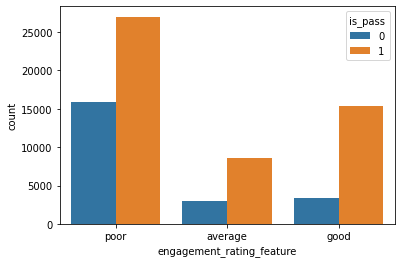

In [0]:
sns.countplot(train_analysis['engagement_rating_feature'],hue=train_analysis['is_pass'])
plt.show()

In [0]:
train_analysis_pycaret = train_analysis[['id','program_id','test_id','trainee_id','program_duration_cat','age','difficulty_test_type','total_programs_enrolled',
                                         'gender','education_tier','is_handicapped','trainee_engagement_rating','is_pass']]
test_analysis_pycaret = test_analysis[['id','program_id','test_id','trainee_id','program_duration_cat','age','difficulty_test_type','total_programs_enrolled',
                                         'gender','education_tier','is_handicapped','trainee_engagement_rating']]

In [0]:
train_analysis_pycaret.sort_index(inplace=True)
train_analysis_pycaret.head()

,id,program_id,test_id,trainee_id,program_duration_cat,age,difficulty_test_type,total_programs_enrolled,gender,education_tier,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y_1,150,9389,max duration,24.0,intermediate_offline,5,M,3_Matriculation,N,1.0,0
1,16523_44,T_1,44,16523,medium1 duration,26.0,easy_offline,2,F,4_High School Diploma,N,3.0,1
2,13987_178,Z_2,178,13987,Minimum duration,40.0,easy_online,1,M,1_Matriculation,N,2.0,1
3,13158_32,T_2,32,13158,Minimum duration,45.0,easy_offline,4,F,3_Matriculation,N,1.0,1
4,10591_84,V_3,84,10591,medium1 duration,42.0,intermediate_offline,2,F,1_High School Diploma,N,4.0,1


In [0]:
test_analysis_pycaret.sort_index(inplace=True)
test_analysis_pycaret.head()

,id,program_id,test_id,trainee_id,program_duration_cat,age,difficulty_test_type,total_programs_enrolled,gender,education_tier,is_handicapped,trainee_engagement_rating
0,1626_45,T_1,45,1626,medium1 duration,46.0,intermediate_offline,2,F,3_Matriculation,N,4.0
1,11020_130,Y_3,130,11020,max duration,45.0,easy_online,4,M,3_Bachelors,N,4.0
2,12652_146,Y_2,146,12652,Minimum duration,45.0,easy_online,2,M,3_Matriculation,N,3.0
3,7038_72,V_4,72,7038,medium1 duration,45.0,vary hard_offline,2,F,1_High School Diploma,N,2.0
4,888_71,V_4,71,888,medium1 duration,45.0,intermediate_offline,2,F,3_Matriculation,N,2.0


In [0]:
le = LabelEncoderExt()
le.fit(train_analysis_pycaret['program_id'])
train_analysis_pycaret['program_id'] = le.transform(train_analysis_pycaret['program_id'])
test_analysis_pycaret['program_id'] = le.transform(test_analysis_pycaret['program_id'])

# le = LabelEncoderExt()
# le.fit(train_analysis_pycaret['program_type'])
# train_analysis_pycaret['program_type'] = le.transform(train_analysis_pycaret['program_type'])
# test_analysis_pycaret['program_type'] = le.transform(test_analysis_pycaret['program_type'])

le = LabelEncoderExt()
le.fit(train_analysis_pycaret['difficulty_test_type'])
train_analysis_pycaret['difficulty_test_type'] = le.transform(train_analysis_pycaret['difficulty_test_type'])
test_analysis_pycaret['difficulty_test_type'] = le.transform(test_analysis_pycaret['difficulty_test_type'])

# le = LabelEncoderExt()
# le.fit(train_analysis_pycaret['difficulty_level'])
# train_analysis_pycaret['difficulty_level'] = le.transform(train_analysis_pycaret['difficulty_level'])
# test_analysis_pycaret['difficulty_level'] = le.transform(test_analysis_pycaret['difficulty_level'])

# le = LabelEncoderExt()
# le.fit(train_analysis_pycaret['test_type'])
# train_analysis_pycaret['test_type'] = le.transform(train_analysis_pycaret['test_type'])
# test_analysis_pycaret['test_type'] = le.transform(test_analysis_pycaret['test_type'])
# le = LabelEncoderExt()
# le.fit(train_analysis_pycaret['engagement_rating_feature'])
# train_analysis_pycaret['engagement_rating_feature'] = le.transform(train_analysis_pycaret['engagement_rating_feature'])
# test_analysis_pycaret['engagement_rating_feature'] = le.transform(test_analysis_pycaret['engagement_rating_feature'])

le = LabelEncoderExt()
le.fit(train_analysis_pycaret['program_duration_cat'])
train_analysis_pycaret['program_duration_cat'] = le.transform(train_analysis_pycaret['program_duration_cat'])
test_analysis_pycaret['program_duration_cat'] = le.transform(test_analysis_pycaret['program_duration_cat'])

# le = LabelEncoderExt()
# le.fit(train_analysis_pycaret['total_programs_enrolled_cat'])
# train_analysis_pycaret['total_programs_enrolled_cat'] = le.transform(train_analysis_pycaret['total_programs_enrolled_cat'])
# test_analysis_pycaret['total_programs_enrolled_cat'] = le.transform(test_analysis_pycaret['total_programs_enrolled_cat'])

le = LabelEncoderExt()
le.fit(train_analysis_pycaret['gender'])
train_analysis_pycaret['gender'] = le.transform(train_analysis_pycaret['gender'])
test_analysis_pycaret['gender'] = le.transform(test_analysis_pycaret['gender'])

le = LabelEncoderExt()
le.fit(train_analysis_pycaret['education_tier'])
train_analysis_pycaret['education_tier'] = le.transform(train_analysis_pycaret['education_tier'])
test_analysis_pycaret['education_tier'] = le.transform(test_analysis_pycaret['education_tier'])

le = LabelEncoderExt()
le.fit(train_analysis_pycaret['is_handicapped'])
train_analysis_pycaret['is_handicapped'] = le.transform(train_analysis_pycaret['is_handicapped'])
test_analysis_pycaret['is_handicapped'] = le.transform(test_analysis_pycaret['is_handicapped'])

In [0]:
## Since pycaret directly takes data as categorical we will convert the data type to float

In [0]:
train_analysis_pycaret['program_duration_cat'].value_counts()

0    23075
2    17032
3    16604
4    16436
Name: program_duration_cat, dtype: int64

In [0]:
train_analysis_pycaret.loc[train_analysis_pycaret['program_duration_cat'] == "Minimum duration","program_cat_label"] = 1
train_analysis_pycaret.loc[train_analysis_pycaret['program_duration_cat'] == "medium1 duration","program_cat_label"] = 2
train_analysis_pycaret.loc[train_analysis_pycaret['program_duration_cat'] == "medium2 duration","program_cat_label"] = 3
train_analysis_pycaret.loc[train_analysis_pycaret['program_duration_cat'] == "max duration","program_cat_label"] = 4

test_analysis_pycaret.loc[test_analysis_pycaret['program_duration_cat'] == "Minimum duration","program_cat_label"] = 1
test_analysis_pycaret.loc[test_analysis_pycaret['program_duration_cat'] == "medium1 duration","program_cat_label"] = 2
test_analysis_pycaret.loc[test_analysis_pycaret['program_duration_cat'] == "medium2 duration","program_cat_label"] = 3
test_analysis_pycaret.loc[test_analysis_pycaret['program_duration_cat'] == "max duration","program_cat_label"] = 4

In [0]:
tier = train_analysis_pycaret['education_tier'].unique()

In [0]:
mydict = {}
for t in tier:
  mydict[t] = 0

In [0]:
mydict

{'1_Bachelors': 0,
 '1_High School Diploma': 0,
 '1_Masters': 0,
 '1_Matriculation': 0,
 '1_No Qualification': 4,
 '2_Bachelors': 0,
 '2_High School Diploma': 0,
 '2_Masters': 0,
 '2_Matriculation': 0,
 '2_No Qualification': 3,
 '3_Bachelors': 0,
 '3_High School Diploma': 0,
 '3_Masters': 0,
 '3_Matriculation': 0,
 '3_No Qualification': 2,
 '4_Bachelors': 0,
 '4_High School Diploma': 0,
 '4_Matriculation': 0,
 '4_No Qualification': 1}

In [0]:
mydict['4_No Qualification'] = 1
mydict['3_No Qualification'] = 2
mydict['2_No Qualification'] = 3
mydict['1_No Qualification'] = 4

mydict['4_Matriculation'] = 5
mydict['3_Matriculation'] = 6
mydict['2_Matriculation'] = 7
mydict['1_Matriculation'] = 8

mydict['4_High School Diploma'] = 9
mydict['3_High School Diploma'] = 10
mydict['2_High School Diploma'] = 11
mydict['1_High School Diploma'] = 12

mydict['4_Bachelors'] = 13
mydict['4_Bachelors'] = 14
mydict['4_Bachelors'] = 15
mydict['4_Bachelors'] = 16

mydict['4_Masters'] = 17
mydict['4_Masters'] = 18
mydict['4_Masters'] = 19
mydict['4_Masters'] = 20

In [0]:
train_analysis_pycaret['education_tier_cat'] = train_analysis_pycaret['education_tier'].map(mydict)
test_analysis_pycaret['education_tier_cat'] = test_analysis_pycaret['education_tier'].map(mydict)

In [0]:
train_analysis_pycaret.head()

,id,program_id,test_id,trainee_id,program_duration_cat,age,difficulty_test_type,total_programs_enrolled,gender,education_tier,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,16,150,9389,2,24.0,4,5,1,13,0,1.0,0
1,16523_44,2,44,16523,3,26.0,1,2,0,16,0,3.0,1
2,13987_178,21,178,13987,0,40.0,2,1,1,3,0,2.0,1
3,13158_32,3,32,13158,0,45.0,1,4,0,13,0,1.0,1
4,10591_84,11,84,10591,3,42.0,4,2,0,1,0,4.0,1


In [0]:
# def resample_data(train_analysis_pycaret):
#   df_majority = train_analysis_pycaret[train_analysis_pycaret.is_pass==1]
#   df_minority = train_analysis_pycaret[train_analysis_pycaret.is_pass==0]
 
#   # Upsample minority class
#   df_minority_upsampled = resample(df_minority, 
#                                    replace=True,     # sample with replacement
#                                    n_samples=50867,    # to match majority class
#                                    random_state=88) # reproducible results
 
#   # Combine majority class with upsampled minority class
#   train_analysis_pycaret_sampled = pd.concat([df_majority, df_minority_upsampled])
#   return train_analysis_pycaret_sampled

In [0]:
# train_analysis_pycaret_sampled = resample_data(train_analysis_pycaret)

In [0]:
train_analysis_pycaret_sampled = train_analysis_pycaret

In [0]:
train_analysis_pycaret_sampled['is_pass'].value_counts()

1    50867
0    22280
Name: is_pass, dtype: int64

In [0]:
# train_analysis_pycaret_sampled['program_duration'] = train_analysis_pycaret_sampled['program_duration'].astype(float)
# test_main_pycaret['program_duration'] = test_main_pycaret['program_duration'].astype(float)
train_analysis_pycaret_sampled['total_programs_enrolled'] = train_analysis_pycaret_sampled['total_programs_enrolled'].astype(float)
test_main_pycaret['total_programs_enrolled'] = test_main_pycaret['total_programs_enrolled'].astype(float)

In [0]:
one_hot_test.shape

(31349, 17)

In [0]:
one_hot_train = pd.get_dummies(train_analysis_pycaret_sampled,columns = ['trainee_engagement_rating'])
one_hot_test = pd.get_dummies(test_analysis_pycaret,columns = ['trainee_engagement_rating'])

In [0]:
one_hot_train.head()

,id,program_id,test_id,trainee_id,program_duration_cat,age,difficulty_test_type,total_programs_enrolled,gender,education_tier,is_handicapped,is_pass,trainee_engagement_rating_1.0,trainee_engagement_rating_2.0,trainee_engagement_rating_3.0,trainee_engagement_rating_4.0,trainee_engagement_rating_5.0
0,9389_150,16,150,9389,2,24.0,4,5.0,1,13,0,0,1,0,0,0,0
1,16523_44,2,44,16523,3,26.0,1,2.0,0,16,0,1,0,0,1,0,0
2,13987_178,21,178,13987,0,40.0,2,1.0,1,3,0,1,0,1,0,0,0
3,13158_32,3,32,13158,0,45.0,1,4.0,0,13,0,1,1,0,0,0,0
4,10591_84,11,84,10591,3,42.0,4,2.0,0,1,0,1,0,0,0,1,0


In [0]:
et = ExtraTreesClassifier(criterion="entropy",n_estimators=200,random_state=88)

In [0]:
one_hot_train.shape

(73147, 17)

In [0]:
X = one_hot_train.drop(columns=["is_pass"])
y = one_hot_train['is_pass']

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=88,k_neighbors=10)
X,y = sm.fit_sample(X,y)

In [0]:
# X = train_analysis_pycaret_sampled.drop(columns="is_pass")
# y = train_analysis_pycaret_sampled['is_pass']

In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, 
                                                      random_state=88,test_size=0.20, stratify=y)

In [0]:
x_train.shape

(81387, 16)

In [0]:
X.shape

(101734, 16)

In [0]:
et.fit(x_train,y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200,
                     n_jobs=None, oob_score=False, random_state=88, verbose=0,
                     warm_start=False)

In [0]:
y_pred_valid = et.predict(x_valid)

In [0]:
evaluate_model(y_valid,y_pred_valid)

confusion matrix
True          0     1
Predicted            
0          8074  1640
1          2100  8533
classification report
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     10174
           1       0.80      0.84      0.82     10173

    accuracy                           0.82     20347
   macro avg       0.82      0.82      0.82     20347
weighted avg       0.82      0.82      0.82     20347

accuracy score
0.8161891187890107


In [0]:
X_test = one_hot_test

In [0]:
X_test.shape

(31349, 16)

In [0]:
y_test = et.predict(X_test)

In [0]:
X_test.head()

,id,program_id,test_id,trainee_id,program_duration_cat,age,difficulty_test_type,total_programs_enrolled,gender,education_tier,is_handicapped,trainee_engagement_rating_1.0,trainee_engagement_rating_2.0,trainee_engagement_rating_3.0,trainee_engagement_rating_4.0,trainee_engagement_rating_5.0
0,1626_45,2,45,1626,3,46.0,4,2,0,13,0,0,0,0,1,0
1,11020_130,18,130,11020,2,45.0,2,4,1,10,0,0,0,0,1,0
2,12652_146,17,146,12652,0,45.0,2,2,1,13,0,0,0,1,0,0
3,7038_72,12,72,7038,3,45.0,5,2,0,1,0,0,1,0,0,0
4,888_71,12,71,888,3,45.0,4,2,0,13,0,0,1,0,0,0


In [0]:
x_train.shape

(81387, 16)

In [0]:
et.feature_importances_

array([0.15279608, 0.03420719, 0.12122459, 0.11123241, 0.04291795,
       0.08045111, 0.07596658, 0.04921231, 0.04330101, 0.08317808,
       0.01775038, 0.07232117, 0.03709961, 0.02663708, 0.03354625,
       0.01815822])

In [0]:
ispass_df = pd.DataFrame(y_test,columns = ["is_pass"])

In [0]:
X_test.reset_index(inplace=True)
ispass_df.reset_index(inplace=True)

In [0]:
submission_index = pd.merge(X_test,ispass_df,how="inner",on="index")[['id','is_pass']]
submission_index.to_csv("submission_extra_tree_v9.csv",index=False)

In [0]:
X_test.shape

(31349, 17)

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rf = RandomForestClassifier(n_estimators=300,criterion='entropy',random_state=88)

In [0]:
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

In [0]:
y_pred_valid = rf.predict(x_valid)

In [0]:
evaluate_model(y_valid,y_pred_valid)

confusion matrix
True           0      1
Predicted              
0          10174      0
1              0  10173
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10174
           1       1.00      1.00      1.00     10173

    accuracy                           1.00     20347
   macro avg       1.00      1.00      1.00     20347
weighted avg       1.00      1.00      1.00     20347

accuracy score
1.0


In [0]:
X_test = one_hot_test

In [0]:
X_test.shape

(31349, 16)

In [0]:
y_test = rf.predict(X_test)

In [0]:
X_test.head()

,id,program_id,test_id,trainee_id,program_duration_cat,age,difficulty_test_type,total_programs_enrolled,gender,education_tier,is_handicapped,trainee_engagement_rating_1.0,trainee_engagement_rating_2.0,trainee_engagement_rating_3.0,trainee_engagement_rating_4.0,trainee_engagement_rating_5.0
0,1626_45,2,45,1626,3,46.0,4,2,0,13,0,0,0,0,1,0
1,11020_130,18,130,11020,2,45.0,2,4,1,10,0,0,0,0,1,0
2,12652_146,17,146,12652,0,45.0,2,2,1,13,0,0,0,1,0,0
3,7038_72,12,72,7038,3,45.0,5,2,0,1,0,0,1,0,0,0
4,888_71,12,71,888,3,45.0,4,2,0,13,0,0,1,0,0,0


In [0]:
x_train.shape

(81387, 16)

In [0]:
ispass_df = pd.DataFrame(y_test,columns = ["is_pass"])

In [0]:
X_test1 = X_test.reset_index(inplace=False)
ispass_df.reset_index(inplace=True)

In [0]:
submission_index = pd.merge(X_test1,ispass_df,how="inner",on="index")[['id','is_pass']]
submission_index.to_csv("submission_random_forest_v.csv",index=False)

In [0]:
submission['is_pass'].value_counts()

1    15888
0    15461
Name: is_pass, dtype: int64

In [0]:
import xgboost as xgboost

In [0]:
xgb = xgboost.XGBRFClassifier(max_depth=10,learning_rate=0.01,n_estimators=200)

In [0]:
xgb.fit(x_train,y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=0.01,
                max_delta_step=0, max_depth=10, min_child_weight=1,
                missing=None, n_estimators=200, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

In [0]:
y_pred_valid = xgb.predict(x_valid)

In [0]:
evaluate_model(y_valid,y_pred_valid)

confusion matrix
True          0     1
Predicted            
0          6746  1057
1          3428  9116
classification report
              precision    recall  f1-score   support

           0       0.86      0.66      0.75     10174
           1       0.73      0.90      0.80     10173

    accuracy                           0.78     20347
   macro avg       0.80      0.78      0.78     20347
weighted avg       0.80      0.78      0.78     20347

accuracy score
0.7795743844301372


In [0]:
X_test = one_hot_test

In [0]:
X_test.shape

(31349, 16)

In [0]:
X_test2 = X_test.values

In [0]:
y_test = xgb.predict(X_test2)

In [0]:
X_test.head()

,id,program_id,test_id,trainee_id,program_duration_cat,age,difficulty_test_type,total_programs_enrolled,gender,education_tier,is_handicapped,trainee_engagement_rating_1.0,trainee_engagement_rating_2.0,trainee_engagement_rating_3.0,trainee_engagement_rating_4.0,trainee_engagement_rating_5.0
0,1626_45,2,45,1626,3,46.0,4,2,0,13,0,0,0,0,1,0
1,11020_130,18,130,11020,2,45.0,2,4,1,10,0,0,0,0,1,0
2,12652_146,17,146,12652,0,45.0,2,2,1,13,0,0,0,1,0,0
3,7038_72,12,72,7038,3,45.0,5,2,0,1,0,0,1,0,0,0
4,888_71,12,71,888,3,45.0,4,2,0,13,0,0,1,0,0,0


In [0]:
x_train.shape

(81387, 16)

In [0]:
ispass_df = pd.DataFrame(y_test,columns = ["is_pass"])

In [0]:
X_test1 = X_test.reset_index(inplace=False)
ispass_df.reset_index(inplace=True)

In [0]:
submission_index = pd.merge(X_test1,ispass_df,how="inner",on="index")[['id','is_pass']]
submission_index.to_csv("submission_random_forest_v12.csv",index=False)